In [115]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [116]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/AMPAIM/'

In [144]:
# get mapping file w metadata; drop row 1
df_map = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# first column is q2 datatypes, an extraneous column (the index 1 is inclusive)
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_meta = df_map.iloc[1:,]

# convert index to str from float etc.
df_meta.index = df_meta.index.map(str)

# switch EISER Diagnosis to eiser
df_meta.loc[df_meta['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# Fix Diagnosis 66 to RA
df_meta.loc['EARA04-V1-plate307',:]['Diagnosis'] = 'RA'

# obtain project value counts
df_meta['Project'].value_counts()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


eiser                194
microteach           106
TWIN_PSA              36
glass_control         11
duplicate_control     10
neg_control            4
Name: Project, dtype: int64

In [147]:
'HostSubjectId' in list(first_row_df.columns.values)

True

In [118]:
# filter out controls into new metadata.tsv
# see job file @ /sc/arion/projects/MMEDS/mmeds_server_data/studies/adamcantor22_AMP_AIM_MSQ_138_0
# should have 194 eiser + 106 microteach + 36 TWIN_PSA = 336 samples
df_meta_filtered = df_meta[df_meta['Project'].isin(['eiser','microteach','TWIN_PSA'])]
df_map_filtered = df_map[df_map.index.isin(list(df_meta_filtered.index.values))].reset_index()

# concat the first row
df_map_filtered = pd.concat([first_row_df, df_map_filtered])

# convert to CSV for Q2
df_map_filtered.to_csv(path + 'inputs/qiime_mapping_file_noctrl.tsv', sep='\t', index=False, na_rep='nan')
df_map_filtered_confirm = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl.tsv', sep='\t', index_col=0, header=0)
#df_map_filtered.to_csv(path + 'inputs/qiime_mapping_file_fix66.tsv', sep='\t', index=False, na_rep='nan')
#df_map_filtered_confirm = pd.read_csv(path + 'inputs/qiime_mapping_file_fix66.tsv', sep='\t', index_col=0, header=0)
df_map_filtered_confirm.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN


In [119]:
df_meta['Diagnosis'].value_counts()

eiser         194
RA             50
psa            36
pso            29
unaffected     14
healthy        11
ss              5
cd              4
sle             4
Name: Diagnosis, dtype: int64

In [120]:
# 14 of these are NaN and don't appear in value_counts, so 25 controls total
neg_controls = df_meta[df_meta['Project'] == 'neg_control'].index.values
df_meta[df_meta['Project'].isin(['glass_control','duplicate_control','neg_control'])]['Diagnosis'].value_counts()


RA         6
healthy    5
Name: Diagnosis, dtype: int64

elution-buffer-plate307
360.0
elution-buffer-plate308
358.0
elution-buffer-plate306
361.0
elution-buffer-plate305
357.0


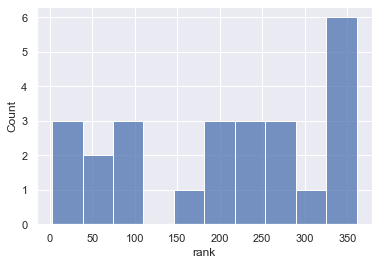

In [121]:
# check control read count relative to sample read count
controls = df_meta[df_meta['Project'].isin(['glass_control','duplicate_control','neg_control'])].index.values
controls = set(controls)
controls

df = pd.read_csv(path + 'inputs/Qiime2_0_KB_fix66/sample-frequency-detail.csv', index_col=0, header=None)
df['rank'] = range(1,362)

ranks = []
for c in controls:
    #print(c)
    if c in neg_controls:
        print(c)
        print(df.loc[c]['rank'])

sns.histplot(data = df.loc[controls], x='rank', bins=10)

In [122]:
# prepare for LEfSe - this is from the Q2 view website and gives ABS counts
df = pd.read_csv(path + 'inputs/Qiime2_0_KB_noctrl/level-6.csv', index_col=0)
# df.iloc[:,0].value_counts()
df.head()


,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__Methanomassiliicoccus,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__vadinCA11,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
index,,,,,,,,,,,,,,,,,,,,,
116783-plate305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [123]:
# get mapping file w metadata WITHOUT controls; drop row 1
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB_noctrl/qiime_mapping_file_noctrl.tsv', sep='\t', header=0, index_col=0)

# first column is q2 datatypes, an extraneous column (the index 1 is inclusive)
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_meta = df_map.iloc[1:,]

# convert index to str from float etc.
df_meta.index = df_meta.index.map(str)

# switch EISER Diagnosis to eiser
df_meta.loc[df_meta['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# remove eiser samples because of study separation effect
df_meta = df_meta[df_meta['Project'] != 'eiser']

# Fix Diagnosis 66 to RA
df_meta.loc['EARA04-V1-plate307',:]['Diagnosis'] = 'RA'
df_meta.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
131-slesjo-plate308,CCGGACAAGAAG,CCGGACTACHVGGGTWTCTAAT,F2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,131-slesjo,NaN,F,fecal,NaN,NaN,NaN
209-pso-plate307,GGCTCGTCGGAG,CCGGACTACHVGGGTWTCTAAT,E1,<5,mild,NaN,NaN,N,N,N,...,NaN,Human,NaN,209-pso,NaN,M,fecal,NaN,NaN,NaN
235-psa-plate307,TGCGCGCCTTCC,CCGGACTACHVGGGTWTCTAAT,E3,<5,mild,NaN,NaN,N,N,N,...,NaN,Human,NaN,235-psa,NaN,F,fecal,NaN,NaN,NaN
240-psa-plate307,GCGCACACCTTC,CCGGACTACHVGGGTWTCTAAT,F3,45214,severe,NaN,NaN,N,N,NaN,...,NaN,Human,NaN,240-psa,NaN,M,fecal,NaN,NaN,NaN
241-pso-plate307,GACATCTGACAC,CCGGACTACHVGGGTWTCTAAT,F1,10-May,moderate,NaN,NaN,N,N,N,...,NaN,Human,NaN,241-pso,NaN,F,fecal,NaN,NaN,NaN


In [124]:
df_meta['Diagnosis'].value_counts()

RA            44
psa           36
pso           29
unaffected    14
healthy        6
ss             5
cd             4
sle            4
Name: Diagnosis, dtype: int64

In [130]:
# for LEfSe, jobs00, RA comparison first

# aggregate healthy and unaffected into healthy
df_meta_RAvH = df_meta[df_meta['Diagnosis'].isin(['RA','unaffected','healthy'])]

# switch unaffected dx to healthy
df_meta_RAvH.loc[df_meta_RAvH['Diagnosis'] == 'unaffected', 'Diagnosis'] = 'healthy'

# export to csv; 44 RA vs 14 unaff + 6 healthy samples
df_meta_RAvH.to_csv(path + 'inputs/qiime_mapping_file_noctrl_RAvH.tsv', sep='\t')
df_meta_RAvH.head()


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,AbxInPast3Months,Age,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,CurrentMTXdose,...,ResultsProcessor,ResultsProtocolID,ResultsMethod,ResultsTool,ResultsToolVersion,BirthYear,Nationality,Sex,SpecimenType,Weight
#SampleID,,,,,,,,,,,,,,,,,,,,,
452-B-plate307,N,25.0,NaN,NaN,250,NaN,N,N,N,NaN,...,NaN,ResultsProtocol241,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN
457-B-plate307,UNCLEAR (taken in the past year),54.0,NaN,NaN,250,3.99,N,N,N,NaN,...,NaN,ResultsProtocol242,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN
458-B-plate307,N,36.0,NaN,NaN,NaN,24.78,N,N,N,NaN,...,NaN,ResultsProtocol243,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN
460-B-plate307,N,48.0,NaN,NaN,250,2.47,N,N,N,NaN,...,NaN,ResultsProtocol244,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN
462-B-plate307,N,49.0,NaN,NaN,250,24.88,N,N,N,NaN,...,NaN,ResultsProtocol245,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN


In [132]:
df_meta_RAvH['Diagnosis'].value_counts()

RA         44
healthy    20
Name: Diagnosis, dtype: int64

In [138]:
df_map.columns.values

array(['BarcodeSequence', 'LinkerPrimerSequence', 'AmpliconWell', 'BSA',
       'BSASeverityByBSA', 'CCPtiter', 'CRP', 'CurrentBiologics',
       'CurrentIntralesionalSteroids', 'CurrentMTX', 'CurrentMTXdose',
       'CurrentOtherDMARDs', 'CurrentParenteralSteroids',
       'CurrentTopicalSteroids', 'CurrentUV', 'DAS28', 'Dactylitis',
       'DaysSinceExperimentStart', 'Diagnosis', 'DiseaseDuration',
       'DrugNaive', 'ESR', 'Enthesitis', 'ExampleMetaData', 'HLAB27',
       'Hispanic', 'HxBiologics', 'HxOtherDMARDs', 'MDHAQ',
       'NumberSamplePlate', 'PhysicianGlobalPsA', 'Plate',
       'ProbioticsInPast1mo', 'ProbioticsInPast3Months', 'Project',
       'PsAtype', 'PsOtype', 'RAPID3', 'RFtiter', 'Race', 'SJC',
       'Separate', 'SkinSwabCollected', 'SomeOtherInfo',
       'StoolCollectDate', 'StoolCollected', 'StoolReceivedDate', 'TJC',
       'TemplateDNAwell', 'Together', 'hxMTX', 'hxParenteralSteroids',
       'AliquotID', 'AliquotWeight', 'AliquotWeightUnit',
       'Specime

In [125]:
# columns to drop
# df_meta.columns.values is 138 columns
keepcol = ['AbxInPast3Months', 'Age', 'BSA', 'BSASeverityByBSA', 'CCPtiter', 'CRP', 'CurrentBiologics',
       'CurrentIntralesionalSteroids', 'CurrentMTX', 'CurrentMTXdose','CurrentOtherDMARDs', 'CurrentParenteralSteroids',
       'CurrentTopicalSteroids', 'CurrentUV', 'DAS28', 'Dactylitis', 'DaysSinceExperimentStart', 'Diagnosis', 'DiseaseDuration',
       'DrugNaive', 'ESR', 'Enthesitis', 'ExampleMetaData', 'HLAB27', 'Hispanic', 'HxBiologics', 'HxOtherDMARDs', 'MDHAQ',
       'PhysicianGlobalPsA', 'Plate', 'ProbioticsInPast1mo', 'ProbioticsInPast3Months', 'PsAtype', 'PsOtype', 'RAPID3', 
       'RFtiter', 'Race', 'SJC', 'SkinSwabCollected', 'SomeOtherInfo', 'StoolCollected', 'TJC',
       'hxMTX', 'hxParenteralSteroids', 'AliquotWeightUnit', 'SpecimenBodySite', 'UberonCodeBodySite', 'Biome', 
       'CollectionSiteName', 'CollectionSiteTechnician', 'Depth', 'Environment', 'Feature', 'Material', 'Ethnicity', 
       'ExperimentName', 'Genotype', 'Height', 'ICDCode', 'IllnessEndDate', 'IllnessInstanceID', 'IllnessNotes', 
       'IllnessStartDate', 'InterventionEndDate', 'InterventionNotes', 'InterventionStartDate', 'InterventionCode', 
       'InterventionName', 'InterventionType', 'SequencingMethod', 'SpecimenID', 'TargetGene', 'ResultID', 'ResultsLocation',
       'ResultsDatePerformed', 'ResultsProcessor', 'ResultsProtocolID', 'ResultsMethod', 'ResultsTool', 'ResultsToolVersion', 
       'BirthYear', 'Nationality', 'Sex', 'SpecimenType', 'Weight']

df_meta = df_meta[keepcol]

df_meta.head()

,AbxInPast3Months,Age,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,CurrentMTXdose,...,ResultsProcessor,ResultsProtocolID,ResultsMethod,ResultsTool,ResultsToolVersion,BirthYear,Nationality,Sex,SpecimenType,Weight
#SampleID,,,,,,,,,,,,,,,,,,,,,
131-slesjo-plate308,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ResultsProtocol302,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN
209-pso-plate307,N,47.0,<5,mild,NaN,NaN,N,N,N,NaN,...,NaN,ResultsProtocol197,NaN,NaN,NaN,NaN,NaN,M,fecal,NaN
235-psa-plate307,NaN,54.0,<5,mild,NaN,NaN,N,N,N,NaN,...,NaN,ResultsProtocol213,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN
240-psa-plate307,NaN,37.0,45214,severe,NaN,NaN,N,N,NaN,NaN,...,NaN,ResultsProtocol214,NaN,NaN,NaN,NaN,NaN,M,fecal,NaN
241-pso-plate307,N,69.0,10-May,moderate,NaN,NaN,N,N,N,NaN,...,NaN,ResultsProtocol198,NaN,NaN,NaN,NaN,NaN,F,fecal,NaN


In [83]:
# plot marginal dist
import os
import matplotlib.pyplot as plt

try:
    os.mkdir(path + 'outputs/marginal/')
except:
    pass

for x in df_meta.columns.values:
    # create a seaborn plot
    sns.set(style="darkgrid")
    ax = sns.displot(df_meta, x=x)

    # save the plot as PNG file
    plt.savefig(path + 'outputs/marginal/' + x + '.png')
    plt.close()

print('Done')

Done


In [8]:
# unnormalized OTU table level-6 also has metadata in it! nice 
df_otu = pd.read_csv(path + 'inputs/adamcantor22_AMP_AIM_MSQ_138_0/Qiime2_0/summary/level-6.csv')
df_otu.index = df_otu['index']

dropcol = ['AmpWellPlate', 
            'AmpliconWell', 
            'DaysSinceExperimentStart', 
            'OtherSubjectID', 
            'Plate',
            'SkinSwabCollected', 
            'SomeOtherInfo', 
            'StoolCollectDate',
            'StoolCollected', 
            'StoolReceivedDate', 
            'TemplateDNAwell',
            'AliquotID', 
            'AliquotWeight',
            'AliquotWeightUnit', 
            'SpecimenBodySite', 
            'UberonCodeBodySite',
            'Biome', 
            'CollectionSiteName', 
            'CollectionSiteTechnician', 
            'Depth',
            'Elevation', 
            'Environment', 
            'Feature', 
            'Latitude', 
            'Longitude',
            'Material', 
            'ExperimentName', 
            'HeightDateCollected', 
            'ContactEmail', 
            'ContactName',
            'PrimaryInvestigator', 
            'BarcodeSequence', 
            'LinkerPrimerSequence',
            #'RawDataID', 
           'HostSubjectId',
            'RawDataNotes', 
            'RawDataDatePerformed',
            'RawDataProcessor', 
            'RawDataProtocolID',
            'FinishingStrategyCoverage', 
            'FinishingStrategyStatus',
            'NumberOfContigs', 
           'index',
            'Primer', 
            'RawDataConditions',
            'SequencingMethod', 
            'TargetGene', 
            'ResultID', 
            'ResultsLocation',
        'ResultsDatePerformed', 'ResultsProcessor', 'ResultsProtocolID',
       'ResultsMethod', 'ResultsTool', 'ResultsToolVersion', 
           #'SampleID',

       'SampleWeight', 'SampleWeightUnit', 'SampleDatePerformed',
       'SampleProcessor', 'SampleProtocolID', 'SampleProtocolNotes',
       'SampleConditions', 'SampleTool', 'SampleToolVersion',
       'SpecimenCollectionDate', 'SpecimenCollectionMethod',
       'SpecimenCollectionTime', 'SpecimenID', 'SpecimenNotes',
       'SpecimenWeight', 'SpecimenWeightUnit', 'StorageFreezer',
       'StorageInstitution', 'RelevantLinks', 'StudyName', 'StudyType',
       'SubjectType', 'HostSubjectId',
       'SpecimenType', 'UberonCodeType', 'WeightDateCollected',
          'MmedsSampleID']

df_otu = df_otu.drop(dropcol, axis=1)
# 
# df_otu.columns.values

# checks for all na columns and drops them
# per pd.Series(df_otu.isnull().values.all(axis=0)).value_counts(), 243 are ok, 19 are all NaN

df_otu = df_otu[df_otu.columns[~df_otu.isnull().values.all(axis=0)]]

# drop subjects
drop_subjID = ['elution-buffer-plate305', 'elution-buffer-plate307', 'elution-buffer-plate308','MOC-307']
df_otu = df_otu.drop(drop_subjID)
drop_meta = ['Separate','Together']
df_otu = df_otu.drop(drop_meta, axis=1)

# df_otu['Diagnosis'].value_counts() confirms the original breakdown of subjects by disease category
# grab OTU cols
otu_cols = [x for x in df_otu.columns.values if x[0:3] == 'k__']

# normalize the OTU cols
df_otu[otu_cols] = df_otu[otu_cols].div(df_otu[otu_cols].sum(axis=1), axis=0)



# subset the PsO/PsA subjects
df_ps = df_otu[df_otu['Diagnosis'].isin(['pso','psa'])]

# drops 240 -> 239
df_ps = df_ps[df_ps.columns[~df_ps.isnull().values.all(axis=0)]]
df_ps.to_csv(path + 'inputs/df_ps.tsv', sep='\t')

# split into otu and meta
df_ps[otu_cols].to_csv(path + 'inputs/df_otu_ps.tsv', sep='\t')
df_ps.drop(otu_cols, axis=1).to_csv(path + 'inputs/df_meta_ps.tsv', sep='\t')


# subjset the RA
df_ra = df_otu[df_otu['Diagnosis'].isin(['RA'])]

# drops 240 -> 232
df_ra = df_ra[df_ra.columns[~df_ra.isnull().values.all(axis=0)]]
df_ra.to_csv(path + 'inputs/df_ra.tsv', sep='\t')

# split into otu and meta
df_ra[otu_cols].to_csv(path + 'inputs/df_otu_ra.tsv', sep='\t')
df_ra.drop(otu_cols, axis=1).to_csv(path + 'inputs/df_meta_ra.tsv', sep='\t')

# subset the healthy
df_healthy = df_otu[df_otu['Diagnosis'] == 'healthy']

# split into otu and meta
df_healthy[otu_cols].to_csv(path + 'inputs/df_otu_healthy.tsv', sep='\t')
df_healthy.drop(otu_cols, axis=1).to_csv(path + 'inputs/df_meta_healthy.tsv', sep='\t')

df_healthy.head()

,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__[Methanomassiliicoccaceae];g__vadinCA11,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;__,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,...,RAPID3,RFtiter,Race,SJC,TJC,hxMTX,hxParenteralSteroids,Age,AbxInPast3Months,Sex
index,,,,,,,,,,,,,,,,,,,,,
MicraHC-1017-B-glass-plate308,0.0,0.0,0.0,0.000437,0.0,0.000000,0.0,0.0,0.000000,0.0,...,NaN,NaN,white,NaN,NaN,NaN,NaN,46.0,N,F
MicraHC-1017-B-plate308,0.0,0.0,0.0,0.000552,0.0,0.000000,0.0,0.0,0.000000,0.0,...,NaN,NaN,white,NaN,NaN,NaN,NaN,46.0,N,F
MicraHC-1018-B-glass-plate308,0.0,0.0,0.0,0.000000,0.0,0.000691,0.0,0.0,0.000115,0.0,...,NaN,NaN,white,NaN,NaN,NaN,NaN,45.0,N,F
MicraHC-1018-B-plate308,0.0,0.0,0.0,0.000000,0.0,0.000801,0.0,0.0,0.000000,0.0,...,NaN,NaN,white,NaN,NaN,NaN,NaN,45.0,N,F
MicraHC-1019-B-glass-plate308,0.0,0.0,0.0,0.000863,0.0,0.000157,0.0,0.0,0.000000,0.0,...,NaN,NaN,white,NaN,NaN,NaN,NaN,46.0,N,M


In [7]:
# for mapping to cutie indices; both are 0 indexed
# this is for ra
taxa = list(df_ra.columns.values)
taxa_interest = ['Phascolarctobacterium', 'Christensenella', 'Paraprevotella']
for t in taxa:
    for i in taxa_interest:
        if i in t:
            print(t)
            print(taxa.index(t))


k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__
41
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__CF231
42
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella
43
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__YRC22
44
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__[Prevotella]
45
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;__
70
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__
71
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__Christensenella
72
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium
124


In [8]:
# for mapping to cutie indices; both are 0 indexed
# this is for ps
taxa = list(df_ra.columns.values)
taxa_interest = ['Oxalobacter','Rikenellaceae', 'Christensenella', 'Paraprevotella']
for t in taxa:
    for i in taxa_interest:
        if i in t:
            print(t)
            print(taxa.index(t))

# 31, 43, 72, 166

k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;__
31
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__
32
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__AF12
33
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes
34
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__human
35
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__
41
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__CF231
42
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella
43
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__YRC22
44
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__[Prevotella]
45
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ch

In [13]:
# PICRUST2
# 387 functional pahtways 
df_fxn = pd.read_csv(path + 'outputs/jobs01/PiCRUSt2_0/picrust2_out/pathways_out/path_abun_unstrat.tsv', sep='\t', index_col=0).T
drop_subjID = ['elution-buffer-plate305', 'elution-buffer-plate307', 'elution-buffer-plate308','MOC-307']
df_fxn = df_fxn.drop(drop_subjID)

# normalize by row total (per sample basis)
df_fxn = df_fxn.div(df_fxn.sum(axis=1), axis=0)
df_fxn.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

# new metadata for concatenation
df_meta_sample = df_meta.set_index('SampleID')

# concatenate
df_pi = pd.concat([df_meta_sample, df_fxn], axis=1)
df_pi.head()

#gene names; KO is just a placeholder
# KO_names = [x for x in df_pi.columns.values if x[0] == 'K']
KO_names = [x for x in df_pi.columns.values if x[-3:] == 'PWY']

# RA first
df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','RA'])]#'pso','psa'])]
# df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
df_ra_KO = df_KO[df_KO['Diagnosis'].isin(['RA'])]#'pso','psa'])]
df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]

df_ra_KO.head()

,AbxInPast3Months,Age,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,CurrentMTXdose,...,THISYN-PWY,THREOCAT-PWY,THRESYN-PWY,TRNA-CHARGING-PWY,TRPSYN-PWY,TYRFUMCAT-PWY,UBISYN-PWY,UDPNAGSYN-PWY,VALDEG-PWY,VALSYN-PWY
452-B-plate307,N,25.0,NaN,NaN,250,NaN,N,N,N,NaN,...,0.003032,0.000001,0.009778,0.009309,0.003667,0.000000,0.000035,0.007420,0.0,0.010943
457-B-plate307,UNCLEAR (taken in the past year),54.0,NaN,NaN,250,3.99,N,N,N,NaN,...,0.003997,0.000013,0.009037,0.008465,0.006007,0.000015,0.000218,0.006079,0.0,0.009624
458-B-plate307,N,36.0,NaN,NaN,NaN,24.78,N,N,N,NaN,...,0.002916,0.000000,0.009363,0.008943,0.006499,0.000000,0.000015,0.007427,0.0,0.010016
460-B-plate307,N,48.0,NaN,NaN,250,2.47,N,N,N,NaN,...,0.003872,0.000020,0.008149,0.008107,0.005136,0.000000,0.000069,0.006539,0.0,0.009841
462-B-plate307,N,49.0,NaN,NaN,250,24.88,N,N,N,NaN,...,0.004351,0.000000,0.008826,0.008238,0.006289,0.000002,0.000036,0.006928,0.0,0.010109


KeyError: 'OtherSubjectID'

In [82]:
pvals = []
KO = KO_names#[0:1000]

# get OG p values
for k in KO:
    x = df_ra_KO[k].values
    y = df_healthy_KO[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    # remove nans or else, but this might not be the best way
    # https://github.com/statsmodels/statsmodels/issues/2899
    if np.isnan(p):
        pvals.append(1)
    else:
        pvals.append(p)

# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
# one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
# scipy.stats.false_discovery_control(ps)

# convert to q values
sig_list = []
for i in range(len(KO)):
    q = qvals[i]
    if q < 0.05:        
        k = KO[i]
        sig_list.append(k)
        
print(len(sig_list))



0


0.036956221197394556
1CMET2-PWY
0.008879221264202618
ANAEROFRUCAT-PWY
0.03496065262072063
ANAGLYCOLYSIS-PWY
0.040081294037828265
BRANCHED-CHAIN-AA-SYN-PWY
0.008718843227514149
CRNFORCAT-PWY
0.01872886772783822
DENITRIFICATION-PWY
0.04503954396368327
DTDPRHAMSYN-PWY
0.024831260645965546
FUC-RHAMCAT-PWY
0.01702959632966568
GLCMANNANAUT-PWY
0.007147879911831653
GLYCOCAT-PWY
0.02734846270978945
GLYCOGENSYNTH-PWY
0.030196014307388865
HEMESYN2-PWY
0.04243184465647184
HOMOSER-METSYN-PWY
0.039147673441873074
ILEUSYN-PWY
0.04979828699220794
MET-SAM-PWY
0.02504091895236655
NONOXIPENT-PWY
0.04556047844044021
P124-PWY
17


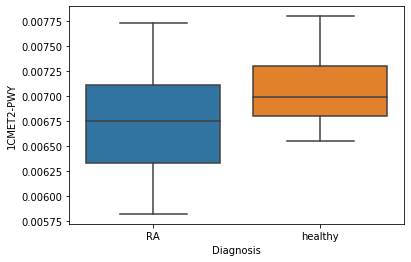

In [85]:
# ILLUSTRATIVE PURPOSES ONLY
pvals = []
KO = KO_names[0:100]
sig_list = []

# get OG p values
for k in KO:
    x = df_ra_KO[k].values
    y = df_healthy_KO[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    if p < 0.05:
        sig_list.append(k)
        print(p)
        print(k)
        
print(len(sig_list)) # out of 100
sns.boxplot(data=df_KO, x='Diagnosis', y=sig_list[0])
# min(qvals)


In [74]:
# PSO PSA next
df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','pso','psa'])]
df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
df_ps_KO = df_KO[df_KO['Diagnosis'].isin(['pso','psa'])]
df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]

df_ps_KO.head()

,1CMET2-PWY,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,AEROBACTINSYN-PWY,ALL-CHORISMATE-PWY,ANAEROFRUCAT-PWY,ANAGLYCOLYSIS-PWY,ARGDEG-PWY,ARGORNPROST-PWY,ARGSYN-PWY,ARGSYNBSUB-PWY,...,THREOCAT-PWY,THRESYN-PWY,TRNA-CHARGING-PWY,TRPSYN-PWY,TYRFUMCAT-PWY,UBISYN-PWY,UDPNAGSYN-PWY,VALDEG-PWY,VALSYN-PWY,Diagnosis
209-pso-plate307,0.006479,0.000000,0.000000,0.000177,0.007334,0.008657,0.000054,0.000391,0.005999,0.006035,...,0.000000,0.007755,0.007064,0.005200,0.000000,0.000131,0.004207,0.000000,0.008580,pso
241-pso-plate307,0.005565,0.000002,0.000000,0.000365,0.006518,0.008106,0.000108,0.000874,0.008457,0.008646,...,0.000031,0.008819,0.008263,0.005852,0.000003,0.000343,0.007648,0.000000,0.010662,pso
260-pso-plate307,0.007265,0.000000,0.000000,0.000036,0.007529,0.008726,0.000011,0.000196,0.005263,0.005364,...,0.000000,0.008426,0.008699,0.005288,0.000008,0.000011,0.005849,0.000000,0.007253,pso
307-pso-plate307,0.005387,0.000708,0.000068,0.000654,0.004559,0.007445,0.000155,0.000836,0.005608,0.005847,...,0.000037,0.006881,0.006299,0.004471,0.000385,0.001015,0.005209,0.000000,0.007918,pso
350-pso-plate307,0.006734,0.000000,0.000000,0.000000,0.006306,0.008863,0.000000,0.000436,0.005004,0.005032,...,0.000000,0.007410,0.007236,0.005749,0.000000,0.000187,0.004249,0.000004,0.008175,pso


In [75]:
pvals = []
KO = KO_names#[0:1000]

# get OG p values
for k in KO:
    x = df_ps_KO[k].values
    y = df_healthy_KO[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    # remove nans or else, but this might not be the best way
    # https://github.com/statsmodels/statsmodels/issues/2899
    if np.isnan(p):
        pvals.append(1)
    else:
        pvals.append(p)

# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
# one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
# scipy.stats.false_discovery_control(ps)

# convert to q values
sig_list = []
for i in range(len(KO)):
    q = qvals[i]
    if q < 0.05:        
        k = KO[i]
        sig_list.append(k)
        
print(len(sig_list))



0


In [76]:
min(qvals)

0.18293278751446262

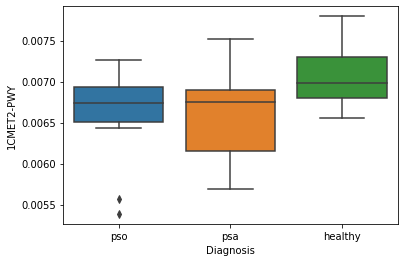

In [77]:
# ILLUSTRATIVE PURPOSES ONLY
pvals = []
KO = KO_names[0:100]
sig_list = []

# get OG p values
for k in KO:
    x = df_ra_KO[k].values
    y = df_healthy_KO[k].values
    t, p = scipy.stats.ttest_ind(x,y)
    if p < 0.05:
        sig_list.append(k)
        

sns.boxplot(data=df_KO, x='Diagnosis', y=sig_list[0])
# min(qvals)


In [38]:
# search for 'twin' in df_meta
# from https://stackoverflow.com/questions/26640129/search-for-string-in-all-pandas-dataframe-columns-and-filter
mask = np.column_stack([df_meta[col].str.contains(r"twin", na=False) for col in df_meta])
df_meta.loc[mask.any(axis=1)]
#df_meta.index.values
# df_meta['Project']

KeyError: 'Project'

In [45]:
# jobs02 case by case
df = pd.read_csv(path + 'outputs/jobs02/data_processing/summary_df_resample_1.txt', sep='\t')
df = df[df['pvalues'] < 0.05]
df = df[df['var2'] == 'RAPID3']
df


,var1,var2,pvalues,correlations,r2vals,TP_rev_indicators,FP_rev_indicators,extreme_p,extreme_r,p_ratio,r2_ratio,class,reverse
796,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,RAPID3,0.041783,0.301419,0.090854,-1.0,-1.0,0.102814,0.246357,2.460693,0.668017,FP,No
1323,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,RAPID3,0.014630,0.357807,0.128026,-1.0,-1.0,0.060789,0.281748,4.155099,0.620048,FP,No
1354,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,RAPID3,0.008587,-0.383123,0.146783,-1.0,-1.0,0.022534,-0.339454,2.624149,0.785028,TP,No
1881,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,RAPID3,0.017903,0.347686,0.120886,-1.0,-1.0,0.032242,0.319784,1.800948,0.845938,TP,No
2036,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,RAPID3,0.047569,0.293717,0.086269,-1.0,-1.0,0.087647,0.257537,1.842533,0.768817,FP,No
2625,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,RAPID3,0.043816,-0.298618,0.089173,-1.0,-1.0,0.094262,-0.252491,2.151286,0.714924,FP,No
3400,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,RAPID3,0.035611,-0.310663,0.096512,-1.0,-1.0,0.078705,-0.264854,2.210126,0.726831,FP,No
3493,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,RAPID3,0.034993,-0.311659,0.097132,-1.0,-1.0,0.074635,-0.268402,2.132832,0.741670,FP,No
4237,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...,RAPID3,0.000510,-0.492300,0.242360,-1.0,-1.0,0.001201,-0.467585,2.353310,0.902113,TP,No
4516,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...,RAPID3,0.046747,-0.294762,0.086885,-1.0,-1.0,0.159748,-0.213163,3.417269,0.522973,FP,No


In [46]:
df['var1'][]

796     k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1323    k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1354    k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1881    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
2036    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
2625    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
3400    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
3493    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4237    k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...
4516    k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...
Name: var1, dtype: object